In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn import manifold

import torch
import torchvision
import torch.nn as nn
from google.colab import drive
from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive')

Mounted at /content/drive


# Build Resnet Autoencoder

In [ ]:
class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate"""

    def __init__(self, size=None, scale_factor=None):
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, size=self.size, scale_factor=self.scale_factor)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


def resize_conv3x3(in_planes, out_planes, scale=1):
    """upsample + 3x3 convolution with padding to avoid checkerboard artifact"""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    else:
        return nn.Sequential(
            Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes)
        )

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def resize_conv1x1(in_planes, out_planes, scale=1):
    """upsample + 1x1 convolution with padding to avoid checkerboard artifact"""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    else:
        return nn.Sequential(
            Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes)
        )
       
class DecoderBlock(nn.Module):
    """
    ResNet block, but convs replaced with resize convs, and channel increase is in
    second conv, not first
    """

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

class DecoderBottleneck(nn.Module):
    """
    ResNet bottleneck, but convs replaced with resize convs
    """

    expansion = 4

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        width = planes  # this needs to change if we want wide resnets
        self.conv1 = resize_conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = resize_conv3x3(width, width, scale)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.scale = scale

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    """
    ResNet block, copied from
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35
    """

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class EncoderBottleneck(nn.Module):
    """
    ResNet bottleneck, copied from
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L75
    """

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        width = planes  # this needs to change if we want wide resnets
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNetEncoder(nn.Module):

    def __init__(self, block, layers, first_conv=False, maxpool1=False):
        super().__init__()

        self.inplanes = 64
        self.first_conv = first_conv
        self.maxpool1 = maxpool1

        if self.first_conv:
            self.conv1 = nn.Conv2d(
                3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
            )
        else:
            self.conv1 = nn.Conv2d(
                3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
            )

        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        if self.maxpool1:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class ResNetDecoder(nn.Module):
    """
    Resnet in reverse order
    """

    def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale_factor=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(
            64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False
        )

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        #x = self.sigmoid(x)
        
        return x

def resnet18_encoder(first_conv=False, maxpool1=False):
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)

def resnet18_decoder(latent_dim, input_height, first_conv=False, maxpool1=False):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)

# Import Data, Create Noisy Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torch.utils.data import Dataset
from torchvision import transforms

batch_size = 128

transform = transforms.Compose([
  transforms.ToTensor(), 
 
])
train_data = CIFAR10(root='data', train=True, transform = transform, download=True)

test_data = CIFAR10(root='data', train=False, transform = transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=False, num_workers=16, pin_memory = True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, num_workers=16, pin_memory = True)

memory_data = CIFAR10(root='data', train=True, transform=transform, download=True)

memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Train Autoencoder

In [ ]:
criterion = nn.MSELoss().cuda()

from tqdm import tqdm


def train(autoencoder, data_loader, optimizer, patience = 5):
  global lr
  last_loss = 0
  counter = 0
  total_loss = 0
  total_num = 0
  data_bar = tqdm(data_loader, position = 0, leave = True)
  with (torch.enable_grad()):
    for img, _ in data_bar:
      output = autoencoder(img.cuda())
      loss = criterion(img.cuda(), output)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_num += img.size(0)
      total_loss += loss.item() * img.size(0)

      desc = 'Train' if train else 'Test'
      data_bar.set_description(f'{desc} Epoch: [{epoch}/{epochs}] lr: {lr:.6f} Loss: {total_loss / total_num:.4f}')
    
    return total_loss / total_num

def test(net, memory_data_loader, test_data_loader, epoch):
    knn_k = 200
    knn_t = 0.1
    global epochs
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting', position = 0, leave = True):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)

        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]

        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader, position = 0, leave = True)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)

            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes,  knn_k, knn_t)
            total_num += data.size(0)
    
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()

            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, epochs, total_top1 / total_num * 100))


def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()
    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)

    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels


In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = resnet18_encoder()
    self.decoder = resnet18_decoder(512, 32)
    

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

autoencoder = Autoencoder()
autoencoder.cuda()
autoencoder.encoder.cuda()
autoencoder.decoder.cuda()
print('done')

done


In [ ]:
lr = 1e-3
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay = 1e-5)


resume = './drive/My Drive/resnet-AE-pure.pth'

if resume is not '':
    checkpoint = torch.load(resume)
    autoencoder.load_state_dict(checkpoint['ae'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(resume))



Loaded from: ./drive/My Drive/resnet-AE-pure.pth


In [ ]:
print(epoch_start)

151


In [ ]:
epochs = 200

last_loss = 9999
patience = 5
counter = 0
for epoch in range(epoch_start, epochs + 1):
  loss = train(autoencoder, train_loader, optimizer)
  test(autoencoder.encoder, memory_loader, test_loader, epoch)
  if loss >= last_loss:
    counter += 1
  else: 
      counter = 0
  if counter == patience:
    lr *= 0.1 
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
  last_loss = loss
  
  torch.save({'epoch': epoch, 'ae': autoencoder.state_dict(), 'encoder': autoencoder.encoder.state_dict(),
                'optimizer' : optimizer.state_dict(),},  './drive/My Drive/resnet-AE-norm-v2.pth')


Test Epoch: [158/200] Acc@1:44.16%: 100%|██████████| 79/79 [00:04<00:00, 16.43it/s]
Train Epoch: [159/200] lr: 0.001000 Loss: 0.0270:  66%|██████▌   | 257/391 [01:29<00:46,  2.90it/s]

KeyboardInterrupt: ignored

# Compare Denoised Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


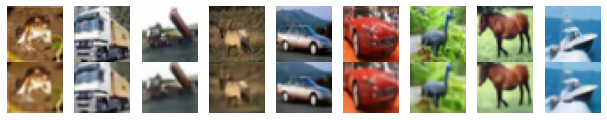

In [ ]:
img, _ = iter(train_loader).next()[:10]

z = autoencoder(img.cuda())

img = np.transpose(img.cpu().detach().numpy(), (0, 2, 3, 1))
z = np.transpose(z.cpu().detach().numpy(), (0, 2, 3, 1))

%matplotlib inline
iter_num=10
start=79
fig = plt.figure(figsize=(60,500), constrained_layout=True)

for i in range(1,iter_num):
  ax1 = fig.add_subplot(34,50,i)
  ax1.set_axis_off()
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  
  ax1.imshow(z[i-1])

for i in range(1,iter_num):
  ax2 = fig.add_subplot(40,50,i)
  ax2.set_axis_off()
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_aspect('equal')
  #prediction = autoencoder.decoder.predict(np.array([z[i].tolist()]))
  ax2.imshow(img[i-1])

plt.subplots_adjust(wspace=None, hspace=None)
plt.show()


# t-SNE Visualisation of Encoder Embedding

In [ ]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#generate tsne projection

x = autoencoder.encoder(train_x[1000:3000].cuda())
x = np.squeeze(x.detach().cpu().numpy())
tsne = manifold.TSNE(n_components=2, init='pca', random_state=3, perplexity=30)
X_tsne = tsne.fit_transform(x)



fig, ax = plt.subplots(figsize=(15,15))
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1],	c=cifar_trainY[1000:3000], s=20, cmap='tab10')

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.show() 

NameError: ignored

# Linear Evaluation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision

for param in autoencoder.encoder.parameters():
    param.requires_grad = False
      
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc = nn.Linear(512, 10, bias = True)
  
  def forward(self, x):
    x = autoencoder.encoder(x)
    x = self.fc(x)
    return x

net = Net()
net.cuda()
lr = 3e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
schedule = [40, 60]

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
data_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=128,
                                          shuffle=True, num_workers=16, pin_memory = True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(data_set, batch_size=128,
                                          shuffle=True, num_workers=16, pin_memory = True)

def train_val(net, data_loader, train_optimizer):
    criterion = nn.CrossEntropyLoss()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()
    global lr
    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()
                

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@3: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
    if is_train:        
      if schedule is not None:
        for milestone in  schedule:
            lr *= 0.1 if epoch == milestone else 1.
        for param_group in train_optimizer.param_groups:
            param_group['lr'] = lr

    return total_loss / total_num, total_correct_1 / total_num * 100, total_correct_3 / total_num * 100

Files already downloaded and verified
Files already downloaded and verified


Resnet denoising autoencoder 100 epochs:
55.5% top 1 , 84% top 3

In [ ]:
epochs = 100
for epoch in range(1, epochs+1):
  train_loss, train_acc_1, train_acc_3 = train_val(net, data_loader, optimizer)
  test_loss, test_acc_1, test_acc_3 = train_val(net, test_loader, None)

Train Epoch: [1/100] Loss: 1.8717 ACC@1: 32.55% ACC@3: 65.57%: 100%|██████████| 391/391 [00:16<00:00, 23.64it/s]
Test Epoch: [1/100] Loss: 1.7306 ACC@1: 38.62% ACC@3: 71.25%: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s]
Train Epoch: [2/100] Loss: 1.6910 ACC@1: 39.94% ACC@3: 73.20%: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]
Test Epoch: [2/100] Loss: 1.6230 ACC@1: 42.89% ACC@3: 75.51%: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s]
Train Epoch: [3/100] Loss: 1.6162 ACC@1: 42.49% ACC@3: 75.49%: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
Test Epoch: [3/100] Loss: 1.5864 ACC@1: 44.50% ACC@3: 76.61%: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s]
Train Epoch: [4/100] Loss: 1.5751 ACC@1: 43.89% ACC@3: 76.65%: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s]
Test Epoch: [4/100] Loss: 1.5497 ACC@1: 43.97% ACC@3: 77.64%: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
Train Epoch: [5/100] Loss: 1.5413 ACC@1: 45.05% ACC@3: 77.80%: 100%|██████████| 391/391 [00:16<00:00

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn import manifold

(trainX, cifar_trainY), (testX, cifar_testY) = tf.keras.datasets.cifar10.load_data()
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
trainY = tf.keras.utils.to_categorical(cifar_trainY)
testY = tf.keras.utils.to_categorical(cifar_testY)
train_x = np.transpose(trainX, (0, 3, 1, 2))
train_x = torch.from_numpy(train_x)

170500096/170498071 [==============================] - 2s 0us/step


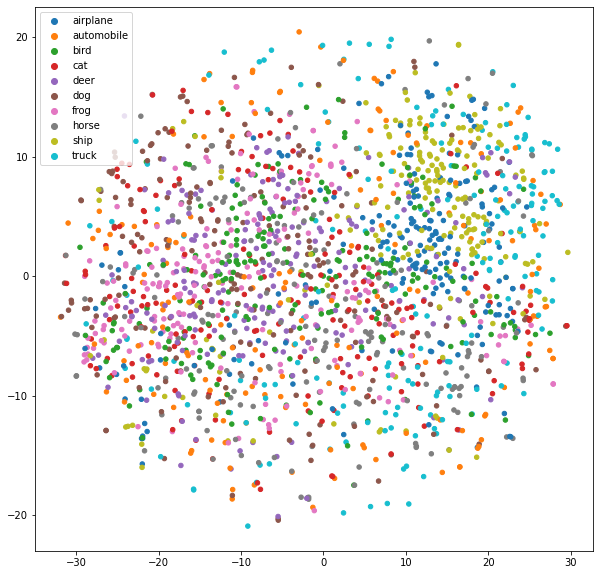

In [ ]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#generate tsne projection

x = autoencoder.encoder(train_x[1000:3000].cuda())
x = np.squeeze(x.detach().cpu().numpy())
tsne = manifold.TSNE(n_components=2, init='pca', random_state=3, perplexity=30)
X_tsne = tsne.fit_transform(x)



fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1],	c=cifar_trainY[1000:3000], s=20, cmap='tab10')

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.show() 

In [ ]:
batch_size = 128 

test_transform = transforms.Compose([
  transforms.ToTensor(), 
  transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])


train_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)


def get_indices(dataset, num_samples):
  indices = []
  for Class in range(10):
    for j in range(num_samples):
      x = np.random.randint(0, 50000)
      while dataset.targets[x] != Class:
        x = np.random.randint(0, 50000)
      indices.append(x)
  return indices



test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
def train_val(net, data_loader, train_optimizer):
    global lr
    schedule = [20, 40]
    criterion = nn.CrossEntropyLoss().cuda()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()


            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            
            data_bar.set_description('{} Epoch: [{}/{}] lr: {:.4f} Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, lr, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
        if is_train:  
          if schedule is not None:
            for milestone in schedule:
                lr *= 0.1 if epoch == milestone else 1.
            for param_group in train_optimizer.param_groups:
                param_group['lr'] = lr

        return total_correct_1/total_num * 100

In [ ]:
train_acc = []
test_acc = []

for layer in autoencoder.parameters():
  layer.requires_grad = False

for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)
  torch.manual_seed(i)

  indices = get_indices(train_data, 100)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(train_data, batch_size=batch_size, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = autoencoder.encoder

  for param in new_model.parameters():
    param.requires_grad = False

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc = nn.Linear(512, 10, bias=True)

    def forward(self, x):
      out = new_model(x)
      #out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
  net = Net()
  net.cuda()
  lr = 3e-4
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)
  epoch_start = 1
  epochs = 60
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)
import numpy as np
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


  0%|          | 0/8 [00:00<?, ?it/s]

Random Seed: 0


Train Epoch: [1/60] lr: 0.0003 Loss: 2.3183 ACC@1: 8.50% ACC@5: 28.90%: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]
Test Epoch: [1/60] lr: 0.0003 Loss: 2.2907 ACC@1: 12.67% ACC@5: 34.58%: 100%|██████████| 79/79 [00:04<00:00, 17.81it/s]
Train Epoch: [2/60] lr: 0.0003 Loss: 2.2834 ACC@1: 13.40% ACC@5: 35.80%: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]
Test Epoch: [2/60] lr: 0.0003 Loss: 2.2677 ACC@1: 13.38% ACC@5: 38.86%: 100%|██████████| 79/79 [00:04<00:00, 16.87it/s]
Train Epoch: [3/60] lr: 0.0003 Loss: 2.2608 ACC@1: 12.40% ACC@5: 40.30%: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]
Test Epoch: [3/60] lr: 0.0003 Loss: 2.2456 ACC@1: 14.84% ACC@5: 45.02%: 100%|██████████| 79/79 [00:04<00:00, 17.02it/s]
Train Epoch: [4/60] lr: 0.0003 Loss: 2.2386 ACC@1: 16.90% ACC@5: 45.70%: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]
Test Epoch: [4/60] lr: 0.0003 Loss: 2.2259 ACC@1: 20.50% ACC@5: 49.02%: 100%|██████████| 79/79 [00:04<00:00, 17.51it/s]
Train Epoch: [5/60] lr: 0.0003 Loss: 2.2160 A

Random Seed: 1


Train Epoch: [1/60] lr: 0.0003 Loss: 2.4022 ACC@1: 10.20% ACC@5: 28.40%: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]
Test Epoch: [1/60] lr: 0.0003 Loss: 2.3209 ACC@1: 10.99% ACC@5: 30.08%: 100%|██████████| 79/79 [00:04<00:00, 16.70it/s]
Train Epoch: [2/60] lr: 0.0003 Loss: 2.3205 ACC@1: 10.00% ACC@5: 31.10%: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]
Test Epoch: [2/60] lr: 0.0003 Loss: 2.3040 ACC@1: 12.05% ACC@5: 32.73%: 100%|██████████| 79/79 [00:04<00:00, 17.30it/s]
Train Epoch: [3/60] lr: 0.0003 Loss: 2.2983 ACC@1: 11.20% ACC@5: 32.10%: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]
Test Epoch: [3/60] lr: 0.0003 Loss: 2.2825 ACC@1: 12.17% ACC@5: 36.13%: 100%|██████████| 79/79 [00:04<00:00, 17.70it/s]
Train Epoch: [4/60] lr: 0.0003 Loss: 2.2707 ACC@1: 12.40% ACC@5: 39.50%: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]
Test Epoch: [4/60] lr: 0.0003 Loss: 2.2572 ACC@1: 15.98% ACC@5: 41.56%: 100%|██████████| 79/79 [00:04<00:00, 17.42it/s]
Train Epoch: [5/60] lr: 0.0003 Loss: 2.2492 

KeyboardInterrupt: ignored